# Train Classifier

In [1]:
import icechunk as ic
import zarr
import xarray as xr
import numpy as np

In [4]:
storage = ic.s3_storage(
    bucket="icechunk-test",
    prefix="dvc-webinar/pyqg-demo-2",
)
repo = ic.Repository.open(storage)
repo

In [5]:
session = repo.readonly_session(branch="main")
group = zarr.open_group(session.store, mode="r")
group_names = list(group)
group_names

['beta=30,rd=15', 'beta=15,rd=15']

In [6]:
ds0 = xr.open_dataset(session.store, group=group_names[0], zarr_format=3, consolidated=False, engine="zarr")
ds1 = xr.open_dataset(session.store, group=group_names[1], zarr_format=3, consolidated=False, engine="zarr")

In [24]:
ds = xr.concat([ds0, ds1], dim=xr.DataArray(group_names, dims=['experiment']))
ds

<xarray.Dataset> Size: 53MB
Dimensions:     (experiment: 2, time: 401, lev: 2, y: 64, x: 64)
Coordinates:
  * lev         (lev) int64 16B 1 2
  * x           (x) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y           (y) float64 512B 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * time        (time) float64 3kB 3.11e+08 3.136e+08 ... 1.345e+09 1.348e+09
  * experiment  (experiment) <U13 104B 'beta=30,rd=15' 'beta=15,rd=15'
Data variables:
    q           (experiment, time, lev, y, x) float64 53MB 1.552e-06 ... 1.33...
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       3e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  1e+99
    pyqg:tc:         187200
    pyqg:tmax:       1347840000.0
    pyqg:twrite:     10000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [26]:
ds_norm = ds / ds.std(('time', 'y', 'x'))

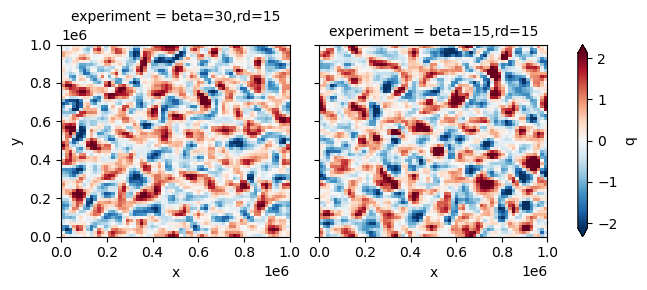

In [34]:
ds_norm.q.isel(lev=0, time=300).plot(col="experiment", robust=True)

In [44]:
from itertools import islice
def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 5)
        self.conv3 = nn.Conv2d(9, 14, 5)
        self.fc1 = nn.Linear(224, 60)
        self.fc2 = nn.Linear(60, 20)
        # output just two values for the two categories
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
all_data = ds_norm.q.isel(lev=0).values

all_labels = np.array(
    [
        all_data.shape[1] * [0,],
        all_data.shape[1] * [1,]
    ]
)

In [49]:
all_data.std(axis=(1, 2, 3))

array([1., 1.])

In [50]:
split = all_data.shape[1] // 4 * 3
data_train = all_data[:, :split]
data_test = all_data[:, split:]
labels_train = all_labels[:, :split]
labels_test = all_labels[:, split:]

s = data_train.shape
# add channel
data_train = data_train.reshape(s[0] * s[1], 1, s[2], s[3])
labels_train = labels_train.flatten()
assert data_train.shape[0] == labels_train.shape[0]

s = data_test.shape
data_test = data_test.reshape(s[0] * s[1], 1, s[2], s[3])
labels_test = labels_test.flatten()
assert data_test.shape[0] == labels_test.shape[0]

In [17]:
batch_size = 10

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(80):  # loop over the dataset multiple times

    sample_index = np.arange(split * 2)
    np.random.shuffle(sample_index)
    
    running_loss = 0.0
    for i, batch_index in enumerate(batched(sample_index, batch_size)):
        # add a channel dimension
        inputs = torch.tensor(data_train[batch_index, :, :, :])
        labels = torch.tensor(labels_train[np.array(batch_index)])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.7f}')
            running_loss = 0.0
            

[1,     1] loss: 0.0003366
[2,     1] loss: 0.0003440
[3,     1] loss: 0.0003472
[4,     1] loss: 0.0003485
[5,     1] loss: 0.0003486
[6,     1] loss: 0.0003461
[7,     1] loss: 0.0003458
[8,     1] loss: 0.0003451
[9,     1] loss: 0.0003465
[10,     1] loss: 0.0003454
[11,     1] loss: 0.0003463
[12,     1] loss: 0.0003462
[13,     1] loss: 0.0003470
[14,     1] loss: 0.0003453
[15,     1] loss: 0.0003465
[16,     1] loss: 0.0003463
[17,     1] loss: 0.0003457
[18,     1] loss: 0.0003464
[19,     1] loss: 0.0003465
[20,     1] loss: 0.0003437
[21,     1] loss: 0.0003446
[22,     1] loss: 0.0003452
[23,     1] loss: 0.0003457
[24,     1] loss: 0.0003463
[25,     1] loss: 0.0003479
[26,     1] loss: 0.0003453
[27,     1] loss: 0.0003442
[28,     1] loss: 0.0003462
[29,     1] loss: 0.0003430
[30,     1] loss: 0.0003445
[31,     1] loss: 0.0003447
[32,     1] loss: 0.0003446
[33,     1] loss: 0.0003420
[34,     1] loss: 0.0003450
[35,     1] loss: 0.0003474
[36,     1] loss: 0.0003439
[

In [35]:
with torch.no_grad():
    predictions = net(torch.tensor(data_test))
    test_loss = criterion(predictions, torch.tensor(labels_test))
test_loss

tensor(0.0479)

In [43]:
results = np.array(list(zip([p.item() for p in predictions.argmax(axis=1)], labels_test)))
(results[:, 0] == results[:, 1]).sum() / len(labels_test)

0.9752475247524752

## Write Model Weights

In [19]:
session = repo.writable_session(branch="main")
group = zarr.open_group(session.store, zarr_format=3)
model_group = group.create_group("model")

In [20]:
for k, v in net.state_dict().items():
    data = v.numpy()
    a = model_group.create_array(k, shape=data.shape, dtype=data.dtype)
    a[:] = data

In [21]:
session.status()

Groups created:
    /model

Arrays created:
    /model/conv1.bias
    /model/conv1.weight
    /model/conv2.bias
    /model/conv2.weight
    /model/conv3.bias
    /model/conv3.weight
    /model/fc1.bias
    /model/fc1.weight
    /model/fc2.bias
    /model/fc2.weight
    /model/fc3.bias
    /model/fc3.weight

User attributes updated:
    /model
    /model/conv1.bias
    /model/conv1.weight
    /model/conv2.bias
    /model/conv2.weight
    /model/conv3.bias
    /model/conv3.weight
    /model/fc1.bias
    /model/fc1.weight
    /model/fc2.bias
    /model/fc2.weight
    /model/fc3.bias
    /model/fc3.weight

Chunks updated:
    /model/conv1.bias:
        [0]
    /model/conv1.weight:
        [0, 0, 0, 0]
    /model/conv2.bias:
        [0]
    /model/conv2.weight:
        [0, 0, 0, 0]
    /model/conv3.bias:
        [0]
    /model/conv3.weight:
        [0, 0, 0, 0]
    /model/fc1.bias:
        [0]
    /model/fc1.weight:
        [0, 0]
    /model/fc2.bias:
        [0]
    /model/fc2.weight:
    

In [22]:
session.commit("added model weights to repo")

'KBRR5675QZY828GSJEPG'